In [47]:
import numpy as np
import cv2
from skimage import exposure
import matplotlib.pyplot as plt

imsize = 400

# Load and resize the content image
content = cv2.imread("./images/house 2-small.jpg")
content = cv2.cvtColor(content, cv2.COLOR_BGR2RGB)

content_copy = content.copy()

content = content[0:imsize, 0:imsize]


# Load and resize the style image
style = cv2.imread("./images/starry-night - small.jpg")
style = cv2.cvtColor(style, cv2.COLOR_BGR2RGB)
style = style[0:imsize, 0:imsize]

(-0.5, 399.5, 399.5, -0.5)

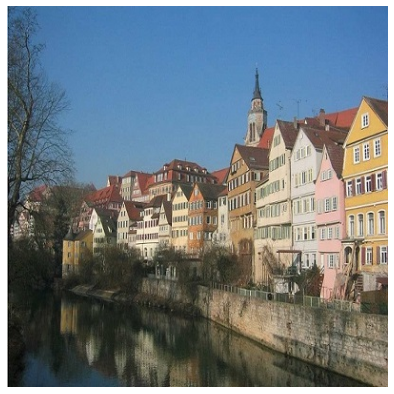

In [48]:
plt.figure(figsize=(15,7))
plt.imshow(content_copy)
plt.axis("off")

(-0.5, 399.5, 399.5, -0.5)

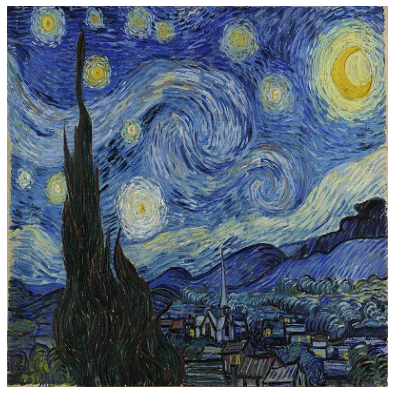

In [49]:
plt.figure(figsize=(15,7))

plt.imshow(style)
plt.axis("off")

In [50]:
# Define a function for style transfer (you need to implement this function)
def color_transfer(content, style, imsize):

        # Initialize variables
    C0 = content.reshape(-1)
    S0 = style.reshape(-1)

    # One-dimensional image
    h0 = imsize
    w0 = imsize

    # number of color channels
    c = 3

    # Convert to 3D arrays
    C0 = C0.reshape(h0, w0, c)
    S0 = S0.reshape(h0, w0, c)

    # Initialize C to color palette of S using histogram matching
    for channel in range(c):
        C0[:, :, channel] = exposure.match_histograms(C0[:, :, channel], S0[:, :, channel])

    C0 = cv2.GaussianBlur(C0, (5, 5), 0)
    # Reshape C0 to a 1D array
    C0 = C0.reshape(-1)

    X = C0
    X = X + np.max(X) * np.random.randn(X.size)  # Add large noise at the beginning
    X = X.reshape(h0, w0, c)
    return X

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


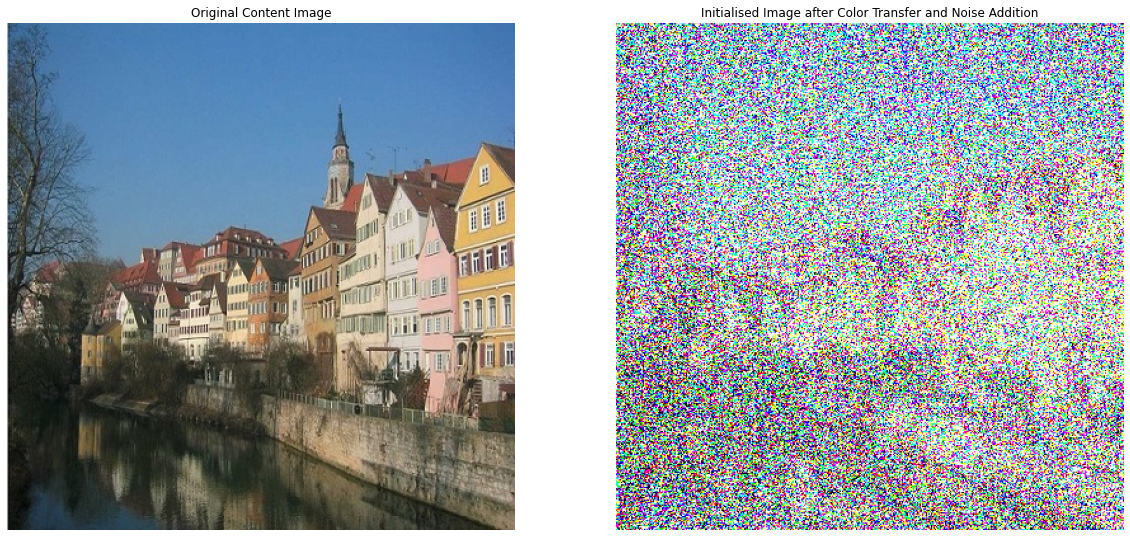

In [52]:
initialised_image = color_transfer(content, style, imsize)
# PLT THIS IMAGE

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.axis("off")
plt.title("Original Content Image")
plt.imshow(content_copy)

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Initialised Image after Color Transfer and Noise Addition") 
plt.imshow(initialised_image)